In [32]:
import pandas as pd
import numpy as np

data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')
df = pd.DataFrame(data)

C:\Users\amits\AppData\Local\Temp\ipykernel_22896\2937067262.py:4: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('matala2_cosmetics_2019-Nov.csv')


In [33]:
#1 - duration to next event

# convert time column to datetime format
df['event_time'] = pd.to_datetime(df['event_time'])

# group by session and get the next time
df['next_time'] = df.groupby('user_session')['event_time'].shift(-1)  

 # calculate the duration in seconds and fill missing values with 0
df['duration_to_next_event'] = (df['next_time'] - df['event_time']).dt.total_seconds().fillna(0) 

# remove the temporary column
df = df.drop('next_time', axis=1)

In [34]:
#2 - funnel number

import datetime

# sort the data by event_time
df = df.sort_values('event_time')

# initialize a dictionary to keep track of the last visit time for each user
last_visit = {}

# initialize a dictionary to keep track of the funnel number for each user
funnel_num = {}

# loop over each row in the data
for index, row in df.iterrows():
    # if this is a new user, set the last visit time and funnel number to None
    if row['user_id'] not in last_visit:
        last_visit[row['user_id']] = None
        funnel_num[row['user_id']] = 1
    
    # if the current session is less than 5 days from the last session, use the same funnel number
    elif last_visit[row['user_id']] is not None and row['event_time'] - last_visit[row['user_id']] <= datetime.timedelta(days=5):
        pass
    
    # otherwise, increment the funnel number
    else:
        funnel_num[row['user_id']] += 1
    
    # update the last visit time for this user
    last_visit[row['user_id']] = row['event_time']
    
    # set the funnel number for this row
    df.at[index, 'funnel_number'] = funnel_num[row['user_id']]

# sort the data by user_id and event_time
df = df.sort_values(['user_id', 'event_time'])


In [35]:
# 3 - index funnel number

df["index_in_funnel"] = df.groupby(["funnel_number", "user_session"]).cumcount() + 1

In [36]:
# 4 - fix prices

import re

df['price'] = df['price'].fillna('').astype(str)

# define a regular expression pattern to extract the price
pattern = r'\d+\.\d+'

# define a function to extract the price and convert it to float
def extract_price(text):
    match = re.search(pattern, text)
    if match:
        return float(match.group(0))
    else:
        return None

# apply the function to the 'price' column
df['price'] = df['price'].apply(extract_price)

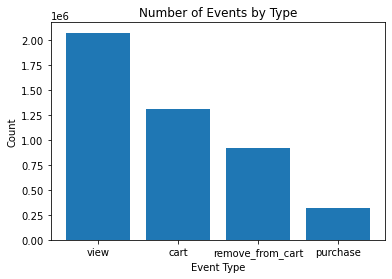

In [38]:
# 5 - event types plot

import matplotlib.pyplot as plt

# Get the unique event types in the data
event_types = data['event_type'].unique()

# Count the number of events for each event type
event_counts = data['event_type'].value_counts()

# Create a bar chart of the event counts
plt.bar(event_types, event_counts)
plt.title('Number of Events by Type')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


In [39]:
# 6 - session data

# create a list to store the session data
session_data_list = []

# group the data by user_id and user_session
grouped = df.groupby(['user_id', 'user_session'])

for name, group in grouped:
    # get the required fields
    user_id = name[0]
    user_session = name[1]
    funnel_number = group['funnel_number'].iloc[0]
    index_in_funnel = group['index_in_funnel'].iloc[0]
    total_events = len(group)
    duration = (group['event_time'].max() - group['event_time'].min()).total_seconds()
    viewed_products = group.loc[group['event_type'] == 'view', 'product_id'].tolist()
    added_to_cart = group.loc[group['event_type'] == 'cart', 'product_id'].tolist()
    purchased = group.loc[group['event_type'] == 'purchase', 'product_id'].tolist()
    
    # create a new row for the session_data dataframe
    session_data_list.append([user_id, user_session, funnel_number, index_in_funnel, total_events, duration, viewed_products, added_to_cart, purchased])

# create the session_data dataframe
session_data = pd.DataFrame(session_data_list, columns=['user_id', 'user_session', 'funnel_number', 'index_in_funnel', 'total_events', 'duration', 'list_of_viewed', 'list_of_added_to_cart', 'list_of_purchased'])